# ITMAL L03

## K-fold CV demo

Code original "Measuring Accuracy Using Cross-Validation", p.108, [HOML]. 

(CEF: code cleaned up, global calls put into functions, changed `StratifiedKFold` to just `SKFold`)


In [1]:
#print("MNIST data get and unpack (slow)..")
#from sklearn.datasets import fetch_openml
#mnist = fetch_openml('mnist_784', version=1)
#print(f"  MNIST keys={mnist.keys()}")
import sys,os
sys.path.append(R'../../UndervisningsGit/GITMAL')

from libitmal import utils as itmalutils


# from libitmal.dataloaders (faster)
from libitmal.dataloaders import MNIST_GetDataSet
X, y = MNIST_GetDataSet(load_mode=0)

print("OK")

11490434/11490434 [==============================] - 1s 0us/step
OK


In [2]:
import numpy as np

print("Design Matrix setup..")

X = X.astype(np.float32)
y = y.astype(np.uint8)

print(f"  X: {X.shape}, y: {y.shape}")

print("Train/test split..")
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

y_train_5 = (y_train == 5)
y_test_5  = (y_test  == 5)

print(f"  Train: X_train: {X_train.shape}, y_train_5: {y_train_5.shape}")
print(f"  Test : X_test:  {X_test.shape}, y_test_5:  {y_test_5.shape}")

print("OK")

Design Matrix setup..
  X: (70000, 784), y: (70000,)
Train/test split..
  Train: X_train: (60000, 784), y_train_5: (60000,)
  Test : X_test:  (10000, 784), y_test_5:  (10000,)
OK


In [3]:
print("SGD model setup and train..")

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

print("\nOK")

SGD model setup and train..

OK


Do some predictions..
  index=42..
    ground_truth=False
    predicted   =[False]
  index=45..
    ground_truth=True
    predicted   =[ True]
OK


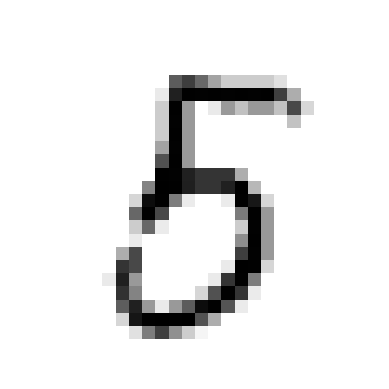

In [5]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_digit(data):
    # NOTE: or just use libitmal.dataloaders.MNIST_GetDataSet
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

def TestPredict(n):
    some_digit = X_test[n]
    ground_truth = y_test_5[n]
    
    plot_digit(some_digit)
    y_pred=sgd_clf.predict([some_digit])
    
    print(f"  index={n}..")
    print(f"    ground_truth={ground_truth}")
    print(f"    predicted   ={y_pred}")
    
print("Do some predictions..")

TestPredict(42)
TestPredict(45)

print("OK")

In [9]:
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def CalcScores(i, y_true, y_pred, doprint=True):
    assert y_true.shape == y_pred.shape, f"mismatch in shapes, y_true.shape={y_true.shape}, y_pred.shape={y_pred.shape}"
    a = accuracy_score (y_true, y_pred)
    p = precision_score(y_true, y_pred)
    r = recall_score   (y_true, y_pred)
    F1= f1_score       (y_true, y_pred)

    if doprint:
        prefix = f"FOLD {i:2d}: " if i>=0 else "" 
        print(f"  {prefix}accuracy={a:.2f}, precision={p:.2f}, recall={r:.2f}, F1={F1:.2f}")

    return a, p, r, F1

def MyKFoldSplit(clf, X, y, kfolds=3, debug=True):
    
    def PrintVarInfo(varname, var):
        assert isinstance(varname, str)
        assert isinstance(var, np.ndarray)
        if debug:
            msg = f"type({varname})"
            t   = f"{type(var)},"
            s   = f"{varname}.shape"
            print(f"  {msg:18s}={t:24s}  {s:18s}={var.shape}")

    scores = []
    i=0
    
    if debug:
        print(f"MyKFoldSplit(clf, X, y, kfolds={kfolds})..")
        PrintVarInfo("X", X)
        PrintVarInfo("y", y)
    
    # skfolds becomes a class sklearn.model_selection._split.KFold..
    skfolds = KFold(n_splits=kfolds, random_state=42, shuffle=True)
    
    for train_index, val_index in skfolds.split(X, y):
        if i==0:
            PrintVarInfo("train_index", train_index)
            PrintVarInfo("val_index",   val_index)
            print()
        
        clone_clf = clone(clf)
        
        X_train_folds = X[train_index]
        y_train_folds = y[train_index]
        X_val_fold    = X[val_index]
        y_val_fold    = y[val_index]

        clone_clf.fit(X_train_folds, y_train_folds)

        y_pred = clone_clf.predict(X_val_fold)

        a, p, r, F1 = CalcScores(i, y_val_fold, y_pred)
        scores.append((a, p, r, F1))
        
        i += 1

        #n_correct = sum(y_pred == y_val_fold)
        #print(n_correct / len(y_pred)) 
        # My    : print  0.95035 0.96035 and 0.9604
        # Gereon: prints 0.9502, 0.96565 and 0.96495
        
    return scores
        
print("K-fold demo..")

scores = MyKFoldSplit(sgd_clf, X_train, y_train_5, 3)

print("OK")

K-fold demo..
MyKFoldSplit(clf, X, y, kfolds=3)..
  type(X)           =<class 'numpy.ndarray'>,  X.shape           =(60000, 784)
  type(y)           =<class 'numpy.ndarray'>,  y.shape           =(60000,)
  type(train_index) =<class 'numpy.ndarray'>,  train_index.shape =(40000,)
  type(val_index)   =<class 'numpy.ndarray'>,  val_index.shape   =(20000,)

  FOLD  0: accuracy=0.97, precision=0.94, recall=0.70, F1=0.80
  FOLD  1: accuracy=0.95, precision=0.67, recall=0.89, F1=0.76
  FOLD  2: accuracy=0.97, precision=0.89, recall=0.73, F1=0.80
OK


In [10]:
print("K-fold mean scores..")

scorenames = ["accuracy ", "precision", "recall   ", "F1       "]
dat = np.array(scores)

for i in range(4):
    d = dat[:,i]
    mean = d.mean()
    std  = d.std()
    print(f"  {scorenames[i]}: {mean:.2f} +/- {std:.3f}")

print("OK")

K-fold mean scores..
  accuracy : 0.96 +/- 0.009
  precision: 0.83 +/- 0.117
  recall   : 0.77 +/- 0.083
  F1       : 0.79 +/- 0.018
OK


In [11]:
print("Final test scores..")

print("  train yet a model with all train data..")
sgd_clf.fit(X_train, y_train_5)        

print("  predict on test data..")
y_test_5_pred = sgd_clf.predict(X_test)
CalcScores(-1, y_test_5, y_test_5_pred)

print("OK")

Final test scores..
  train yet a model with all train data..
  predict on test data..
  accuracy=0.95, precision=0.66, recall=0.88, F1=0.76
OK


REVISIONS||
:- | :- |
2021-??-??| CEF, initial.
2023-02-13| CEF, minor updates and comments, updated section and page numbers for HOML 3rd ed.
2024-02-13| CEF, minor code changes.